## Practica 2 - Parte 1
### Perceptron

#### Importar librerías:

In [386]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import random

#### Dataset:
Cargamos el dataset de iris de la libreria sklearn, al cargar load_iris en iris obtenemos diferentes sets de informacion, guardamos la informacion que nos interesa en un daframe de pandas.

Elimino del dataset los de target = 2 por que solo tenemos que diferenciar entre 2 tipos de iris

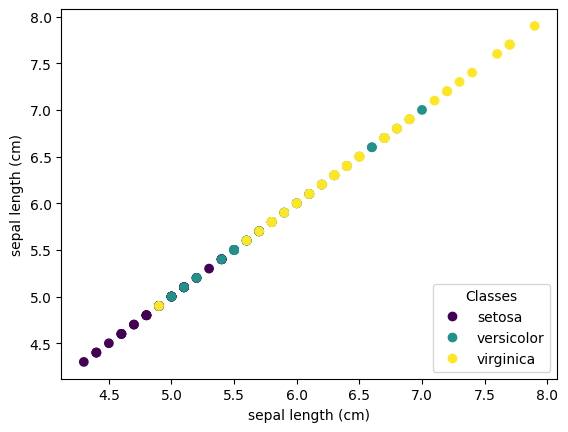

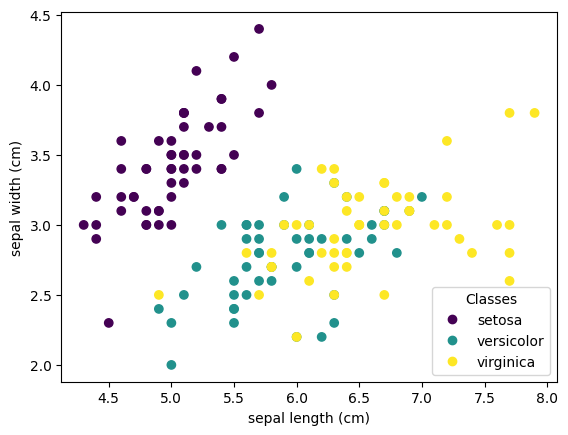

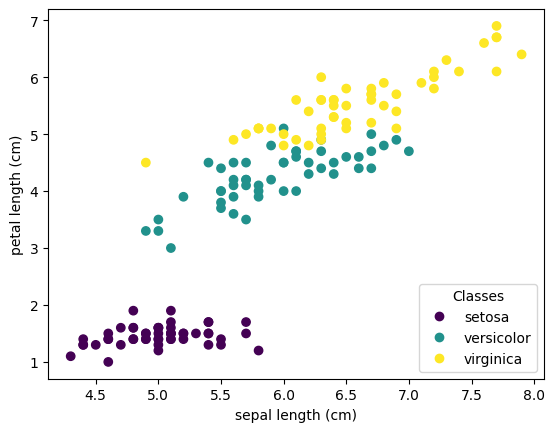

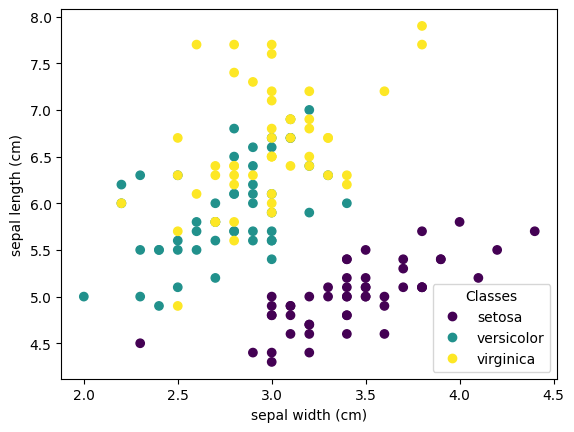

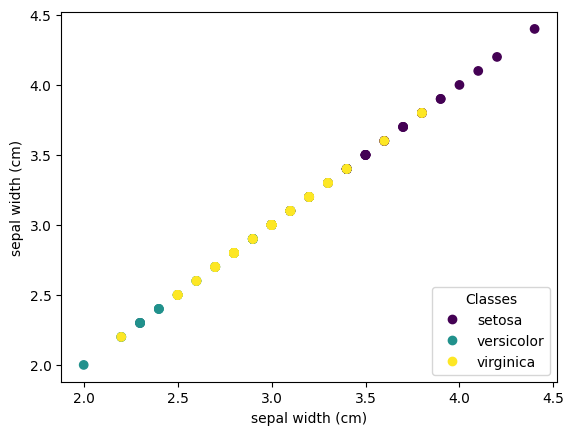

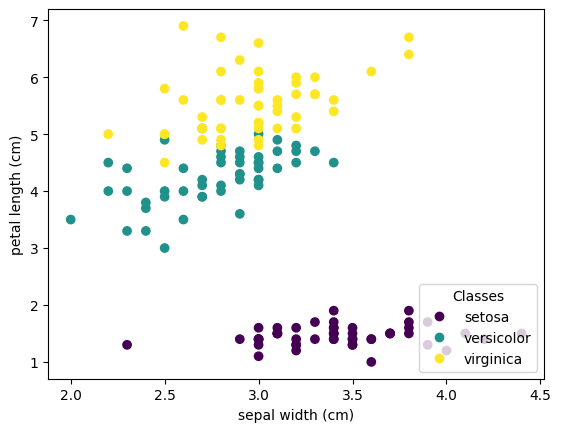

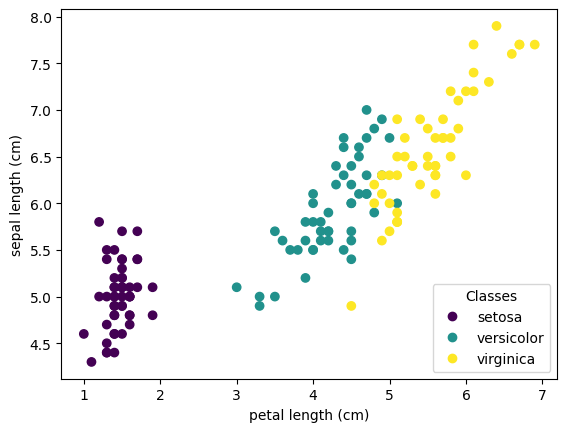

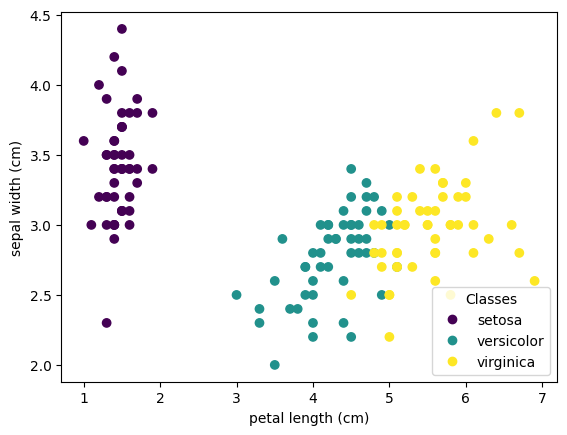

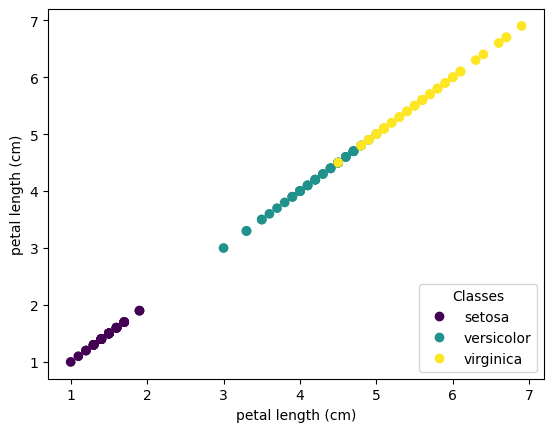

In [387]:
iris = datasets.load_iris()
for i in range (0, 3):
    for j in range (0, 3):
        _, ax = plt.subplots()
        scatter = ax.scatter(iris.data[:, i], iris.data[:, j], c=iris.target)
        ax.set(xlabel=iris.feature_names[i], ylabel=iris.feature_names[j])
        _ = ax.legend(
            scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
        )


In [388]:

iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                        columns= iris['feature_names'] + ['target'])
iris_df = iris_df.query('target != 2')
iris_df


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1.0
96,5.7,2.9,4.2,1.3,1.0
97,6.2,2.9,4.3,1.3,1.0
98,5.1,2.5,3.0,1.1,1.0


Funcion para nomralizar con L2 las 4 primeras columnas del dataframe

In [389]:
def normalize_l2(df, columns):
  """
  Normalizes specified columns in a dataframe using L2 norm.

  Args:
      df: The pandas dataframe.
      columns: List of column names to normalize.

  Returns:
      A new dataframe with normalized columns.
  """
  df_norm = df.copy()
  for col in columns:
    # Calculate L2 norm for each row
    norm = df[col].apply(lambda x: np.sqrt(sum(x**2 for x in df[col])))

    # Avoid division by zero (rows with all zeros)
    norm[norm == 0] = 1

    # Normalize the column values
    df_norm[col] = df[col] / norm
  return df_norm

# Normalize the first 4 columns
iris_normalizados = normalize_l2(iris_df.copy(), iris_df.columns[:-1])

Setosa = 0


#### Variables para el perceptron:

In [390]:
num_entradas = 2
tasa_aprendizaje = 0.1
iteraciones = 100
umbral = 0.1
pesosIniciales = np.random.uniform(-1.0, 1.0, size=(num_entradas,))

Nos quedamos con el 60% de los datos para entrenar y el 40% para comprobar

In [391]:
# Nos quedamos con la columna 2 y 3 de los datos
iris_datos_2_datos_y_target = iris_normalizados.iloc[:, [2, 3, 4]].values

num_datos = len(iris_datos_2_datos_y_target)
num_datos_entrenamiento = int(num_datos * 0.6)
num_datos_test = num_datos - num_datos_entrenamiento

np.random.shuffle(iris_datos_2_datos_y_target)

iris_entrenamiento = iris_datos_2_datos_y_target[:num_datos_entrenamiento]
iris_test = iris_datos_2_datos_y_target[num_datos_entrenamiento:]



In [398]:
pesosIniciales

array([-0.90701504,  0.7174415 ])

##### Entrenamiento
* Función de activación


In [392]:
def activation_func(value):    #Tangent Hypotenuse
    #return (1/(1+np.exp(-value)))
    return ((np.exp(value)-np.exp(-value))/(np.exp(value)+np.exp(-value)))

def perceptron_train(in_data,labels,eta, umbral):
    X=np.array(in_data)
    y=np.array(labels)
    weights= pesosIniciales.copy()
    for key in range(X.shape[0]):
        a=activation_func(np.matmul(np.transpose(weights),X[key]))     
        yn=0
        if a>=umbral:
            yn=1
        elif a<=(-umbral):
            yn=-1
        weights=weights+eta*(yn-y[key])*X[key]
    return weights


##### Comprobar resultados 

In [393]:
def perceptron_test(in_data,label_shape,weights, umbral):
    X=np.array(in_data)
    y=np.zeros(label_shape)
    for key in range(X.shape[1]):
        a=activation_func((weights*X[key]).sum())
        y[key]=0
        if a>=umbral:
            y[key]=1
        elif a<=(-umbral):
            y[key]=-1
    return y

def score(result,labels):
    difference=result-np.array(labels)                                                        
    correct_ctr=0
    for elem in range(difference.shape[0]):
        if difference[elem]==0:
            correct_ctr+=1
    score=correct_ctr*100/difference.size
    return score

In [396]:
datos_entrenamiento = iris_entrenamiento[:, :-1]
target_entrenamiento = iris_entrenamiento[:, -1]

datos_test = iris_test[:, :-1]
indices_test = iris_test[:, -1]
# Lista de learning rates
learning_rates = [0.01, 0.05, 0.1, 0.5, 1.0]

# Lista de umbrales
umbrales = [0.0, 0.1, 0.2, 0.3, 0.4]

for coeficiente_aprendizaje in learning_rates:
  for umbral in umbrales:
    pesos_finales = perceptron_train(datos_entrenamiento, target_entrenamiento, coeficiente_aprendizaje, umbral)
    resultados = perceptron_test(datos_test, indices_test.shape, pesos_finales, umbral)
    puntuacion = score(resultados, indices_test)
    print("Tasa de aprendizaje:", tasa_aprendizaje)
    print("Umbral:", umbral)
    print("Pesos finales:", pesos_finales)
    print("Puntuación:", puntuacion)
    print("-" * 50)



Tasa de aprendizaje: 0.1
Umbral: 0.0
Pesos finales: [-0.99815164  0.63021386]
Puntuación: 45.0
--------------------------------------------------
Tasa de aprendizaje: 0.1
Umbral: 0.1
Pesos finales: [-0.94559204  0.67760444]
Puntuación: 47.5
--------------------------------------------------
Tasa de aprendizaje: 0.1
Umbral: 0.2
Pesos finales: [-0.94559204  0.67760444]
Puntuación: 47.5
--------------------------------------------------
Tasa de aprendizaje: 0.1
Umbral: 0.3
Pesos finales: [-0.94559204  0.67760444]
Puntuación: 47.5
--------------------------------------------------
Tasa de aprendizaje: 0.1
Umbral: 0.4
Pesos finales: [-0.94559204  0.67760444]
Puntuación: 47.5
--------------------------------------------------
Tasa de aprendizaje: 0.1
Umbral: 0.0
Pesos finales: [-1.36269802  0.28130329]
Puntuación: 45.0
--------------------------------------------------
Tasa de aprendizaje: 0.1
Umbral: 0.1
Pesos finales: [-1.09990003  0.5182562 ]
Puntuación: 47.5
-----------------------------

In [397]:
pesosIniciales

array([-0.90701504,  0.7174415 ])